Basic code first trying if attention based linear descent works and minimises loss to a comparable level for linear and logistic regression.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_mse(w, X, y):
    y_pred = X.dot(w)
    return np.mean((y_pred - y)**2)

def loss_bce(w, X, y):
    h = sigmoid(X.dot(w))
    return -np.mean(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))

Generate data for testing

In [ ]:
np.random.seed(42)
N_SAMPLES = 100
X_base = np.c_[np.ones((N_SAMPLES, 1)), 2 * np.random.rand(N_SAMPLES, 2)]
TRUE_W = np.array([[4], [3], [-1.5]]) # True weights for Linear model

y_lin = X_base.dot(TRUE_W) + np.random.randn(N_SAMPLES, 1) * 0.5

# Using a simple plane to define 2 classes and adding noise
y_log_raw = X_base.dot(np.array([[-1], [2], [1]]))
y_log = (sigmoid(y_log_raw) > 0.5).astype(int)

In [ ]:
def attention_search_optimizer(initial_w, X, y, loss_func, n_iterations=2000, n_samples=20, sigma=0.05, beta=10):
    w = initial_w
    loss_history = []

    for i in range(n_iterations):

        # Sample trial parameter vectors
        noise = np.random.randn(n_samples, w.shape[0]) * sigma
        trial_ws = w.T + noise

        # Calculating attention scores and weights (with losses)
        losses = np.array([loss_func(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -beta * losses
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))

        # Computing context vector
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new

        loss_history.append(loss_func(w, X, y))

    final_mse = loss_history[-1]
    return w, final_mse, loss_history

def gradient_descent_optimizer(initial_w, X_b, y, loss_func, is_logistic=False, learning_rate=0.01, n_iterations=2000):
    w=initial_w
    m = len(y)
    loss_history = []

    for _ in range(n_iterations):
        if is_logistic:
            # Gradient for Logistic Regression (BCE Loss)
            h = sigmoid(X_b.dot(w))
            gradient = (1/m) * X_b.T.dot(h - y)
        else:
            # Gradient for Linear Regression (MSE Loss)
            errors = X_b.dot(w) - y
            gradient = (2/m) * X_b.T.dot(errors)

        w = w - learning_rate * gradient
        loss_history.append(loss_func(w, X_b, y))

    return w, loss_history[-1], loss_history

N_ITERS = 2000
initial_w = np.random.randn(X_base.shape[1], 1)

In [ ]:
# Linear Regression (MSE Loss)
w_gd_lin, mse_gd_lin, hist_gd_lin = gradient_descent_optimizer(initial_w, X_base, y_lin, loss_mse, is_logistic=False, learning_rate=0.01, n_iterations=N_ITERS)
w_attn_lin, mse_attn_lin, hist_attn_lin = attention_search_optimizer(initial_w, X_base, y_lin, loss_mse, n_iterations=N_ITERS)

# Logistic Regression (BCE Loss)
initial_w_log = np.random.randn(X_base.shape[1], 1)
w_gd_log, mse_gd_log, hist_gd_log = gradient_descent_optimizer(initial_w, X_base, y_log, loss_bce, is_logistic=True, learning_rate=0.1, n_iterations=N_ITERS)
w_attn_log, mse_attn_log, hist_attn_log = attention_search_optimizer(initial_w_log, X_base, y_log, loss_bce, n_iterations=N_ITERS, sigma=0.1)

print(f"Total Iterations: {N_ITERS}\n")
print("Linear Regression Results (MSE)")
print(f"GD Final Loss: {mse_gd_lin:.4f} | Attn Final Loss: {mse_attn_lin:.4f}")
print("Logistic Regression Results (BCE)")
print(f"GD Final Loss: {mse_gd_log:.4f} | Attn Final Loss: {mse_attn_log:.4f}")

Total Iterations: 2000

Linear Regression Results (MSE)
GD Final Loss: 0.2454 | Attn Final Loss: 0.2471
Logistic Regression Results (BCE)
GD Final Loss: 0.1033 | Attn Final Loss: 0.0998


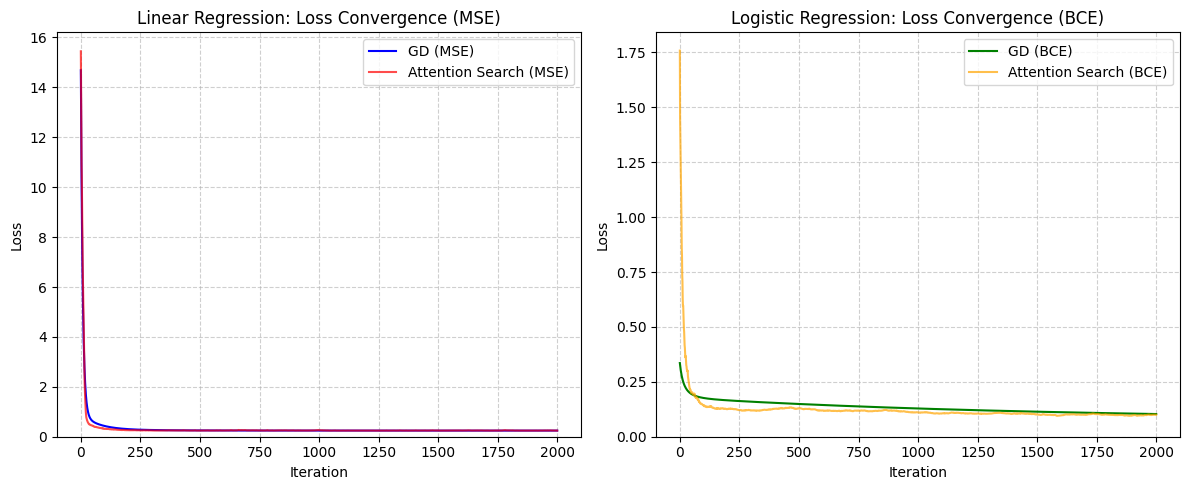

In [ ]:
plt.figure(figsize=(12, 5))

# Linear Regression Comparison
plt.subplot(1, 2, 1)
plt.plot(hist_gd_lin, label='GD (MSE)', color='blue')
plt.plot(hist_attn_lin, label='Attention Search (MSE)', color='red', alpha=0.7)
plt.title('Linear Regression: Loss Convergence (MSE)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)

# Logistic Regression Comparison
plt.subplot(1, 2, 2)
plt.plot(hist_gd_log, label='GD (BCE)', color='green')
plt.plot(hist_attn_log, label='Attention Search (BCE)', color='orange', alpha=0.7)
plt.title('Logistic Regression: Loss Convergence (BCE)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

Testing out with more dimensions than just 3

In [ ]:
def generate_data(n_samples, n_features, model_type):
    # +1 for the bias term
    X = np.random.randn(n_samples, n_features)
    X_b = np.c_[np.ones((n_samples, 1)), X]

    # True weights (random for high dim)
    true_w = np.random.randn(n_features + 1, 1) * 0.5

    if model_type == 'linear':
        y = X_b.dot(true_w) + np.random.randn(n_samples, 1) * 0.1
        loss_func = loss_mse
    elif model_type == 'logistic':
        y_raw = X_b.dot(true_w)
        y = (sigmoid(y_raw) > 0.5).astype(int)
        loss_func = loss_bce
    else:
        raise ValueError("Invalid model type")

    return X_b, y, true_w, loss_func

In attention, now adding exploration too to improve upon GD and not get stuck at local minimas. Also measuring time stats

In [ ]:
def attention_search_optimizer(initial_w, X, y, loss_func, n_iterations=5000, n_exploit=15, sigma_exploit=0.01, n_explore=5, sigma_explore=0.5, beta=10, threshold=None):
    w = initial_w
    loss_history = []

    start_time = time.perf_counter()
    time_to_threshold = None
    iter_to_threshold = None

    for i in range(n_iterations):
        # Exploitation Samples (nearby)
        noise_exploit = np.random.randn(n_exploit, w.shape[0]) * sigma_exploit
        trial_ws_exploit = w.T + noise_exploit

        # Exploration Samples (far-off)
        noise_explore = np.random.randn(n_explore, w.shape[0]) * sigma_explore
        trial_ws_explore = w.T + noise_explore

        # Combine all trial vectors
        trial_ws = np.vstack([trial_ws_exploit, trial_ws_explore])

        # Calculate attention scores and weights (with losses)
        losses = np.array([loss_func(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -beta * losses
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))

        # Compute context vector (New parameter w)
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new

        # Record Loss
        current_loss = loss_func(w, X, y)
        loss_history.append(current_loss)

        # Check Threshold
        if threshold is not None and current_loss < threshold and iter_to_threshold is None:
            iter_to_threshold = i + 1
            time_to_threshold = time.perf_counter() - start_time

    total_time = time.perf_counter() - start_time
    final_mse = loss_history[-1]
    n_total_samples = n_exploit + n_explore

    stats = {
        'total_time': total_time,
        'time_per_iter': total_time / n_iterations,
        'iter_to_threshold': iter_to_threshold,
        'time_to_threshold': time_to_threshold,
        'num_samples_per_iter': n_total_samples,
    }

    return w, final_mse, loss_history, stats

def gradient_descent_optimizer(initial_w, X_b, y, loss_func, is_logistic=False, learning_rate=0.01, n_iterations=5000, threshold=None):
    w = initial_w
    m = len(y)
    loss_history = []

    start_time = time.perf_counter()
    time_to_threshold = None
    iter_to_threshold = None

    for i in range(n_iterations):
        t_grad_start = time.perf_counter()
        if is_logistic:
            h = sigmoid(X_b.dot(w))
            gradient = (1/m) * X_b.T.dot(h - y)
        else:
            errors = X_b.dot(w) - y
            gradient = (2/m) * X_b.T.dot(errors)
        w = w - learning_rate * gradient
        t_grad_end = time.perf_counter()
        current_loss = loss_func(w, X_b, y)
        loss_history.append(current_loss)

        if threshold is not None and current_loss < threshold and iter_to_threshold is None:
            iter_to_threshold = i + 1
            time_to_threshold = time.perf_counter() - start_time

    total_time = time.perf_counter() - start_time
    final_mse = loss_history[-1]

    stats = {
        'total_time': total_time,
        'time_per_iter': total_time / n_iterations,
        'iter_to_threshold': iter_to_threshold,
        'time_to_threshold': time_to_threshold,
        'num_samples_per_iter': 1, # Makes no sense in GD
    }

    return w, final_mse, loss_history, stats


In [ ]:
CONFIGS = [
    # Linear Regression - Low Dim
    {'name': 'Linear Low-D (Exploitation Focus)', 'model_type': 'linear', 'n_features': 10, 'threshold': 0.03, 'lr_gd': 0.01, 'sigma_exploit': 0.01, 'sigma_explore': 0.5},
    # Logistic Regression - High Dim (More complex problem)
    {'name': 'Logistic High-D (Exploration Focus)', 'model_type': 'logistic', 'n_features': 50, 'threshold': 0.2, 'lr_gd': 0.1, 'sigma_exploit': 0.05, 'sigma_explore': 2.0}
]

N_SAMPLES_DATA = 500
N_ITERS = 1000

all_results = defaultdict(lambda: defaultdict(dict))
plot_data = {}

for config in CONFIGS:
    name = config['name']
    n_features = config['n_features']
    threshold = config['threshold']

    # Generating data
    X_b, y, true_w, loss_func = generate_data(N_SAMPLES_DATA, n_features, config['model_type'])
    initial_w = np.random.randn(n_features + 1, 1)

    print(f"\n Running Experiment: {name} (D={n_features+1})")

    w_gd, loss_gd, hist_gd, stats_gd = gradient_descent_optimizer(
        initial_w, X_b, y, loss_func, is_logistic=(config['model_type']=='logistic'),
        learning_rate=config['lr_gd'], n_iterations=N_ITERS, threshold=threshold
    )
    all_results[name]['GD'] = {'loss': loss_gd, 'stats': stats_gd}
    plot_data[f'{name}_GD'] = hist_gd

    w_attn, loss_attn, hist_attn, stats_attn = attention_search_optimizer(
        initial_w, X_b, y, loss_func, n_iterations=N_ITERS,
        n_exploit=25, sigma_exploit=config['sigma_exploit'],
        n_explore=5, sigma_explore=config['sigma_explore'],
        threshold=threshold
    )
    all_results[name]['Attn'] = {'loss': loss_attn, 'stats': stats_attn}
    plot_data[f'{name}_Attn'] = hist_attn


 Running Experiment: Linear Low-D (Exploitation Focus) (D=11)

 Running Experiment: Logistic High-D (Exploration Focus) (D=51)


In [ ]:
print("EXPERIMENT STATISTICS")

for name in CONFIGS:
    exp_name = name['name']

    print(f"\n{exp_name} (D={name['n_features']+1}, Threshold: {name['threshold']})")
    print("| Metric | Gradient Descent | Attention Search |")

    # Time per iteration
    gd_t_iter = all_results[exp_name]['GD']['stats']['time_per_iter'] * 1000 # ms
    attn_t_iter = all_results[exp_name]['Attn']['stats']['time_per_iter'] * 1000 # ms
    print(f"| Time/Iter (ms) | {gd_t_iter:.3f} | {attn_t_iter:.3f} |")

    # Number of samples
    gd_samples = all_results[exp_name]['GD']['stats']['num_samples_per_iter']
    attn_samples = all_results[exp_name]['Attn']['stats']['num_samples_per_iter']
    print(f"| # Samples/Iter | {gd_samples} | {attn_samples} |")

    # Threshold Time/Iters
    gd_iter_th = all_results[exp_name]['GD']['stats']['iter_to_threshold']
    attn_iter_th = all_results[exp_name]['Attn']['stats']['iter_to_threshold']
    gd_time_th = all_results[exp_name]['GD']['stats']['time_to_threshold']
    attn_time_th = all_results[exp_name]['Attn']['stats']['time_to_threshold']

    gd_time_str = f"{gd_time_th:.2f}" if gd_time_th is not None else 'N/A'
    attn_time_str = f"{attn_time_th:.2f}" if attn_time_th is not None else 'N/A'

    # Final Loss
    gd_loss = all_results[exp_name]['GD']['loss']
    attn_loss = all_results[exp_name]['Attn']['loss']
    print(f"| Final Loss | {gd_loss:.4f} | {attn_loss:.4f} |")


EXPERIMENT STATISTICS

Linear Low-D (Exploitation Focus) (D=11, Threshold: 0.03)
| Metric | Gradient Descent | Attention Search |
| Time/Iter (ms) | 0.032 | 0.615 |
| # Samples/Iter | 1 | 30 |
| Final Loss | 0.0102 | 0.0532 |

Logistic High-D (Exploration Focus) (D=51, Threshold: 0.2)
| Metric | Gradient Descent | Attention Search |
| Time/Iter (ms) | 0.105 | 2.100 |
| # Samples/Iter | 1 | 30 |
| Final Loss | 0.0817 | 0.1995 |


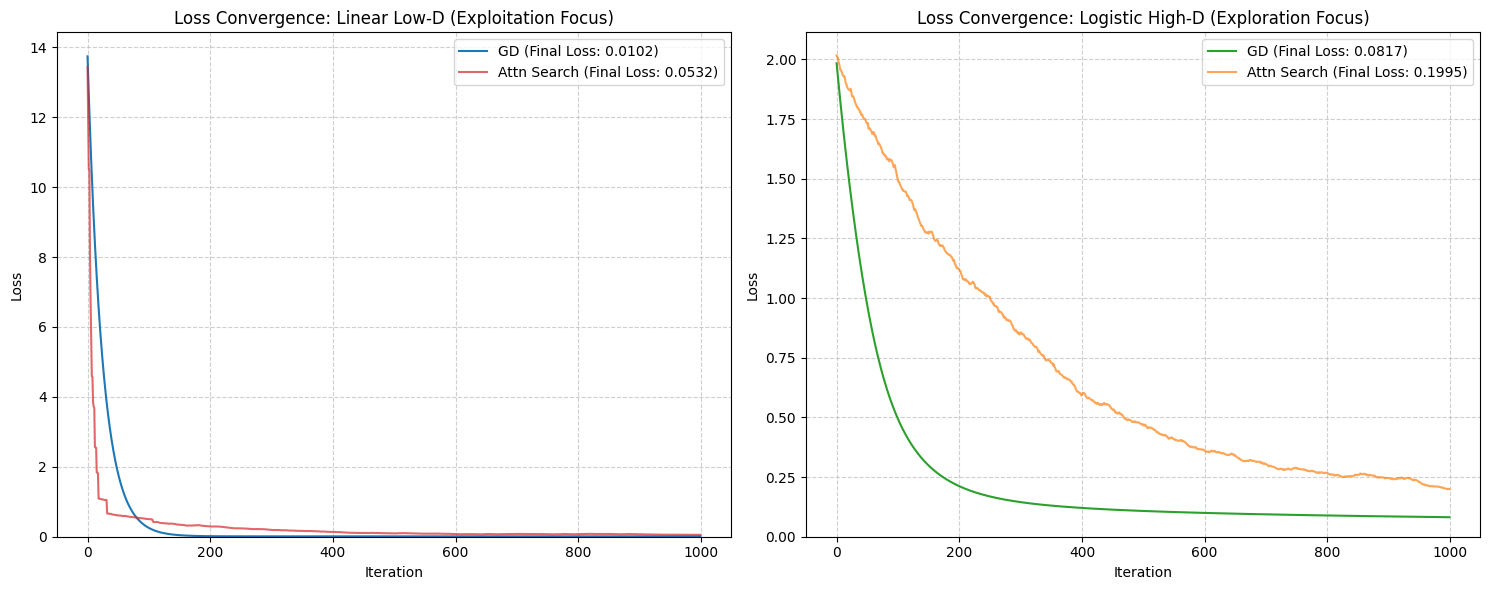

In [ ]:
# Loss Convergence Plot
plt.figure(figsize=(15, 6))

# Low-Dimensional Problem
plt.subplot(1, 2, 1)
name_low_d = CONFIGS[0]['name']
plt.plot(plot_data[f'{name_low_d}_GD'], label=f'GD (Final Loss: {all_results[name_low_d]["GD"]["loss"]:.4f})', color='tab:blue')
plt.plot(plot_data[f'{name_low_d}_Attn'], label=f'Attn Search (Final Loss: {all_results[name_low_d]["Attn"]["loss"]:.4f})', color='tab:red', alpha=0.7)
plt.title(f'Loss Convergence: {name_low_d}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)

# High-Dimensional Problem
plt.subplot(1, 2, 2)
name_high_d = CONFIGS[1]['name']
plt.plot(plot_data[f'{name_high_d}_GD'], label=f'GD (Final Loss: {all_results[name_high_d]["GD"]["loss"]:.4f})', color='tab:green')
plt.plot(plot_data[f'{name_high_d}_Attn'], label=f'Attn Search (Final Loss: {all_results[name_high_d]["Attn"]["loss"]:.4f})', color='tab:orange', alpha=0.7)
plt.title(f'Loss Convergence: {name_high_d}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

For a neural network

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def loss_bce(w, X, y, input_dim, hidden_dim, output_dim):
    N = X.shape[0]

    # Reshape weights from the flat vector 'w'
    W1_size = input_dim * hidden_dim
    W2_size = hidden_dim * output_dim
    B1_size = hidden_dim
    B2_size = output_dim

    # Check if the total size matches the w vector size
    if w.size != W1_size + B1_size + W2_size + B2_size:
        raise ValueError("Weight vector size mismatch!")

    W1 = w[:W1_size].reshape(input_dim, hidden_dim)
    B1 = w[W1_size : W1_size + B1_size].reshape(1, hidden_dim)
    W2 = w[W1_size + B1_size : W1_size + B1_size + W2_size].reshape(hidden_dim, output_dim)
    B2 = w[W1_size + B1_size + W2_size :].reshape(1, output_dim)

    # Forward Propagation
    Z1 = X @ W1 + B1 # (N, hidden_dim)
    A1 = relu(Z1)     # (N, hidden_dim)
    Z2 = A1 @ W2 + B2 # (N, output_dim)
    A2 = sigmoid(Z2)  # Final prediction (N, 1)

    # Calculate BCE Loss
    epsilon = 1e-10
    loss = -np.mean(y * np.log(A2 + epsilon) + (1 - y) * np.log(1 - A2 + epsilon))
    return loss

def generate_nn_data(n_samples, n_features):
    X = np.random.randn(n_samples, n_features)
    # Defining a complex classification boundary using sine/cosine for nonlinearity
    y_raw = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.sum(X[:, 2:], axis=1) * 0.1
    y = (y_raw > np.mean(y_raw)).astype(int).reshape(-1, 1)
    return X, y


In [ ]:
INPUT_DIM = 20
HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_ITERS = 500

# Calculating the total number of parameters (Total dim of w vector)
W1_D = INPUT_DIM * HIDDEN_DIM
B1_D = HIDDEN_DIM
W2_D = HIDDEN_DIM * OUTPUT_DIM
B2_D = OUTPUT_DIM
TOTAL_PARAMS = W1_D + B1_D + W2_D + B2_D

# Generate and split data
X_data, y_data = generate_nn_data(n_samples=1000, n_features=INPUT_DIM)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
nn_loss_func = lambda w, X, y: loss_bce(w, X, y, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def attention_search_optimizer_nn(initial_w, X, y, loss_func, config, threshold=None):
    w = initial_w
    loss_history = []
    n_exploit, sigma_exploit = config['n_exploit'], config['sigma_exploit']
    n_explore, sigma_explore = config['n_explore'], config['sigma_explore']
    n_iterations, beta = config['n_iterations'], config['beta']

    start_time = time.perf_counter()
    time_to_threshold = None
    iter_to_threshold = None

    for i in range(n_iterations):
        # Exploitation samples (nearby)
        # Dimensions: (n_exploit, TOTAL_PARAMS)
        noise_exploit = np.random.randn(n_exploit, w.shape[0]) * sigma_exploit
        trial_ws_exploit = w.T + noise_exploit

        # Exploration samples (far-off)
        # Dimensions: (n_explore, TOTAL_PARAMS)
        noise_explore = np.random.randn(n_explore, w.shape[0]) * sigma_explore
        trial_ws_explore = w.T + noise_explore

        trial_ws = np.vstack([trial_ws_exploit, trial_ws_explore])

        # Calculate attention scores and weights (using losses)
        losses = np.array([loss_func(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -beta * losses
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new

        current_loss = loss_func(w, X, y)
        loss_history.append(current_loss)

        if threshold is not None and current_loss < threshold:
            if iter_to_threshold is None:
                iter_to_threshold = i + 1
                time_to_threshold = time.perf_counter() - start_time
            break # Stop iterating once threshold is met

    total_time = time.perf_counter() - start_time
    final_loss = loss_history[-1]

    stats = {
        'total_time': total_time,
        'time_per_iter': total_time / len(loss_history) if len(loss_history) > 0 else 0,
        'iter_to_threshold': iter_to_threshold,
        'time_to_threshold': time_to_threshold,
        'num_samples_per_iter': n_exploit + n_explore,
    }

    return w, final_loss, loss_history, stats

def gradient_descent_optimizer_nn(initial_w, X, y, config, threshold=None):
    w = initial_w
    learning_rate = config['lr_gd']
    n_iterations = config['n_iterations']
    loss_history = []

    input_dim, hidden_dim, output_dim = INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM
    global W1_D, B1_D, W2_D, B2_D
    m = X.shape[0]

    def unpack_w(w):
        W1 = w[:W1_D].reshape(input_dim, hidden_dim)
        B1 = w[W1_D : W1_D + B1_D].reshape(1, hidden_dim)
        W2 = w[W1_D + B1_D : W1_D + B1_D + W2_D].reshape(hidden_dim, output_dim)
        B2 = w[W1_D + B1_D + W2_D :].reshape(1, output_dim)
        return W1, B1, W2, B2

    start_time = time.perf_counter()
    time_to_threshold = None
    iter_to_threshold = None

    for i in range(n_iterations):
        W1, B1, W2, B2 = unpack_w(w)

        # Forward pass
        Z1 = X @ W1 + B1
        A1 = relu(Z1)
        Z2 = A1 @ W2 + B2
        A2 = sigmoid(Z2)

        # Backpropagation
        dZ2 = A2 - y
        dW2 = A1.T @ dZ2 / m
        dB2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * (Z1 > 0)

        dW1 = X.T @ dZ1 / m
        dB1 = np.sum(dZ1, axis=0, keepdims=True) / m

        grad_flat = np.concatenate([
            dW1.flatten(), dB1.flatten(),
            dW2.flatten(), dB2.flatten()
        ]).reshape(-1, 1)

        w = w - learning_rate * grad_flat
        current_loss = loss_bce(w, X, y, input_dim, hidden_dim, output_dim)
        loss_history.append(current_loss)

        if threshold is not None and current_loss < threshold:
            if iter_to_threshold is None:
                iter_to_threshold = i + 1
                time_to_threshold = time.perf_counter() - start_time
            break # Stop iterating once threshold is met

    total_time = time.perf_counter() - start_time
    final_loss = loss_history[-1]

    stats = {
        'total_time': total_time,
        'time_per_iter': total_time / len(loss_history) if len(loss_history) > 0 else 0,
        'iter_to_threshold': iter_to_threshold,
        'time_to_threshold': time_to_threshold,
        'num_samples_per_iter': 1, # GD implicitly uses 1 sample (the whole batch)
    }

    return w, final_loss, loss_history, stats

NN OPTIMIZATION: GD vs. ATTENTION SEARCH
Model: Two-Layer MLP | Dimensions: 20x50x1 | Total Parameters (w D): 1101

Performance Statistics
| Metric | Gradient Descent (Backprop) | Attention Search (ES-Style) |
| Time/Iter (ms) | 1.370 | 11.439 |
| # Samples/Iter | 1 (Full Batch) | 20 (Black Box) |
| Iters to Target Loss (0.52) | 96 | 40 |
| Time to Target Loss (s) | 0.13 | 0.46 |
| Final Training Loss | 0.5199 | 0.5180 |
| Final Validation Loss | 0.5326 | 0.5411 |


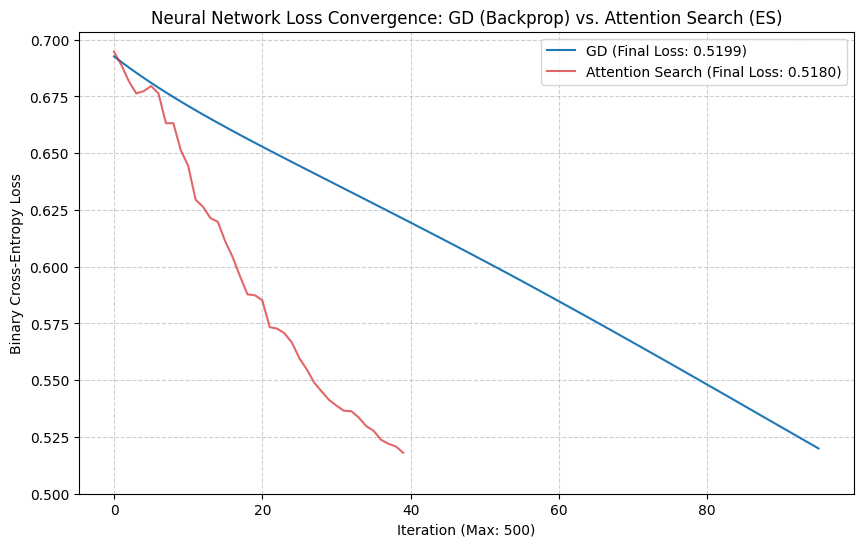

In [ ]:
NN_CONFIG = {
    'name': 'Neural Network (D={})'.format(TOTAL_PARAMS),
    'n_iterations': N_ITERS,
    'threshold': 0.52, # Adjusted threshold to demonstrate GD reaching it

    'lr_gd': 0.05,

    # Attn Search Parameters (Tuning the balance)
    'n_exploit': 10,
    'sigma_exploit': 0.01,
    'n_explore': 10,
    'sigma_explore': 0.1,
    'beta': 30
}

# Initial weights for the total parameter vector
np.random.seed(42) # Add seed for reproducibility
initial_w = np.random.randn(TOTAL_PARAMS, 1) * 0.1

# Run GD (Backpropagation)
w_gd, loss_gd, hist_gd, stats_gd = gradient_descent_optimizer_nn(
    initial_w.copy(), X_train, y_train, NN_CONFIG, threshold=NN_CONFIG['threshold']
)

# Run Attention Search
w_attn, loss_attn, hist_attn, stats_attn = attention_search_optimizer_nn(
    initial_w.copy(), X_train, y_train, nn_loss_func, NN_CONFIG, threshold=NN_CONFIG['threshold']
)

print("NN OPTIMIZATION: GD vs. ATTENTION SEARCH")
print(f"Model: Two-Layer MLP | Dimensions: {INPUT_DIM}x{HIDDEN_DIM}x{OUTPUT_DIM} | Total Parameters (w D): {TOTAL_PARAMS}")

# Statistics Table
print("\nPerformance Statistics")
print("| Metric | Gradient Descent (Backprop) | Attention Search (ES-Style) |")

# Time per iteration
gd_t_iter = stats_gd['time_per_iter'] * 1000
attn_t_iter = stats_attn['time_per_iter'] * 1000
print(f"| Time/Iter (ms) | {gd_t_iter:.3f} | {attn_t_iter:.3f} |")

# Number of samples
gd_samples = stats_gd['num_samples_per_iter']
attn_samples = stats_attn['num_samples_per_iter']
print(f"| # Samples/Iter | {gd_samples} (Full Batch) | {attn_samples} (Black Box) |")

# Threshold Time/Iters
gd_iter_th = stats_gd['iter_to_threshold']
attn_iter_th = stats_attn['iter_to_threshold']
gd_time_th = stats_gd['time_to_threshold']
attn_time_th = stats_attn['time_to_threshold']

gd_time_str = f"{gd_time_th:.2f}" if gd_time_th is not None else 'N/A'
attn_time_str = f"{attn_time_th:.2f}" if attn_time_th is not None else 'N/A'

print(f"| Iters to Target Loss ({NN_CONFIG['threshold']}) | {gd_iter_th if gd_iter_th else 'N/A'} | {attn_iter_th if attn_iter_th else 'N/A'} |")
print(f"| Time to Target Loss (s) | {gd_time_str} | {attn_time_str} |")

# Final Loss (Training)
print(f"| Final Training Loss | {loss_gd:.4f} | {loss_attn:.4f} |")

# Validation check (True performance comparison)
final_val_loss_gd = nn_loss_func(w_gd, X_test, y_test)
final_val_loss_attn = nn_loss_func(w_attn, X_test, y_test)
print(f"| Final Validation Loss | {final_val_loss_gd:.4f} | {final_val_loss_attn:.4f} |")


# Loss Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(hist_gd, label=f'GD (Final Loss: {loss_gd:.4f})', color='tab:blue')
plt.plot(hist_attn, label=f'Attention Search (Final Loss: {loss_attn:.4f})', color='tab:red', alpha=0.7)

plt.title('Neural Network Loss Convergence: GD (Backprop) vs. Attention Search (ES)')
plt.xlabel(f'Iteration (Max: {N_ITERS})')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.5)
plt.show()

Checking a non-convex loss function with a lot of local minimas. GD would get stuck while our method ideally shouldn't.

In [ ]:
# Non-Convex Loss Function (MSE + Oscillation)
def loss_non_convex(w, X, y, lambda_osc=0.8, scale_osc=50):
    y_pred = X.dot(w)
    mse = np.mean((y_pred - y)**2)

    # Oscillation term based on the magnitude of weights
    w_magnitude = np.sum(w**2)
    oscillation = lambda_osc * np.sin(scale_osc * w_magnitude)

    # We add a fixed constant to ensure the loss is positive and to show that GD struggles
    return mse + oscillation + 1.0

def gradient_non_convex(w, X, y, lambda_osc=0.5, scale_osc=10):
    m = len(y)
    errors = X.dot(w) - y
    grad_mse = (2/m) * X.T.dot(errors)
    # Gradient of Oscillation: lambda * cos(scale * w^2) * (2 * scale * w)
    w_magnitude = np.sum(w**2)
    grad_osc = lambda_osc * np.cos(scale_osc * w_magnitude) * (2 * scale_osc * w)

    return grad_mse + grad_osc

# Data Generation for 3-Parameter Problem (w0, w1, w2)
np.random.seed(42)
N_SAMPLES = 100
X = 2 * np.random.rand(N_SAMPLES, 2)
X_b = np.c_[np.ones((N_SAMPLES, 1)), X]
true_w = np.array([[1.0], [2.0], [1.0]])
y = X_b.dot(true_w) + np.random.randn(N_SAMPLES, 1) * 0.1

In [ ]:
def gradient_descent_optimizer_nc(initial_w, X_b, y, learning_rate=0.01, n_iterations=2000):
    w = initial_w
    loss_history = []

    for _ in range(n_iterations):
        grad = gradient_non_convex(w, X_b, y)
        w = w - learning_rate * grad
        loss_history.append(loss_non_convex(w, X_b, y))

    return w, loss_history[-1], loss_history

def attention_search_optimizer_nc(initial_w, X, y, n_iterations=2000, n_samples=30, sigma=0.1):
    w = initial_w.copy()
    loss_history = []

    for _ in range(n_iterations):
        # Sampling
        noise = np.random.randn(n_samples, w.shape[0]) * sigma
        trial_ws = w.T + noise

        # Scoring and Attention
        losses = np.array([loss_non_convex(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -10 * losses # Fixed beta as 10
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))

        # Context Vector Update
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new
        loss_history.append(loss_non_convex(w, X, y))

    return w, loss_history[-1], loss_history


--- Code 1: Non-Convex Loss Comparison (Escaping Local Minima) ---
GD Final Loss: 2.1901 | Attn Final Loss: 0.9633
Note: A lower final loss indicates success in escaping local minima.


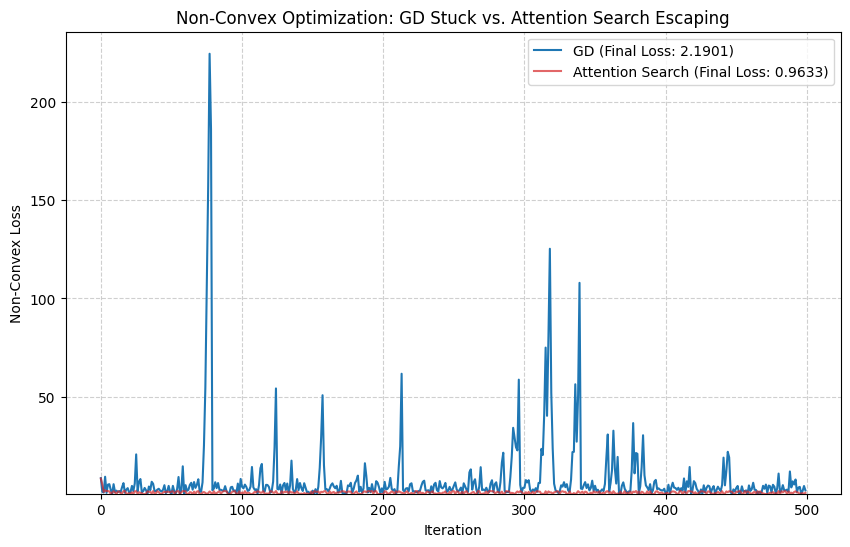

In [ ]:
N_ITERS = 500
initial_w = np.random.randn(X_b.shape[1], 1) * 0.5

w_gd, loss_gd, hist_gd = gradient_descent_optimizer_nc(initial_w, X_b, y, n_iterations=N_ITERS, learning_rate=0.05)
w_attn, loss_attn, hist_attn = attention_search_optimizer_nc(initial_w, X_b, y, n_iterations=N_ITERS, sigma=0.2)


print("\nNon-Convex Loss Comparison (Escaping Local Minima)")
print(f"GD Final Loss: {loss_gd:.4f} | Attn Final Loss: {loss_attn:.4f}")
print("Note: A lower final loss indicates success in escaping local minima.")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hist_gd, label=f'GD (Final Loss: {loss_gd:.4f})', color='tab:blue')
plt.plot(hist_attn, label=f'Attention Search (Final Loss: {loss_attn:.4f})', color='tab:red', alpha=0.7)

plt.title('Non-Convex Optimization: GD Stuck vs. Attention Search Escaping')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.5)
plt.show()

Other non-convex function


Non-Convex Trapping Scenario
GD Learning Rate: 0.001 | GD Final Loss (Trapped): 11.1305
Attn Search Sigma: 0.5 | Attn Final Loss (Escaped): 0.3167


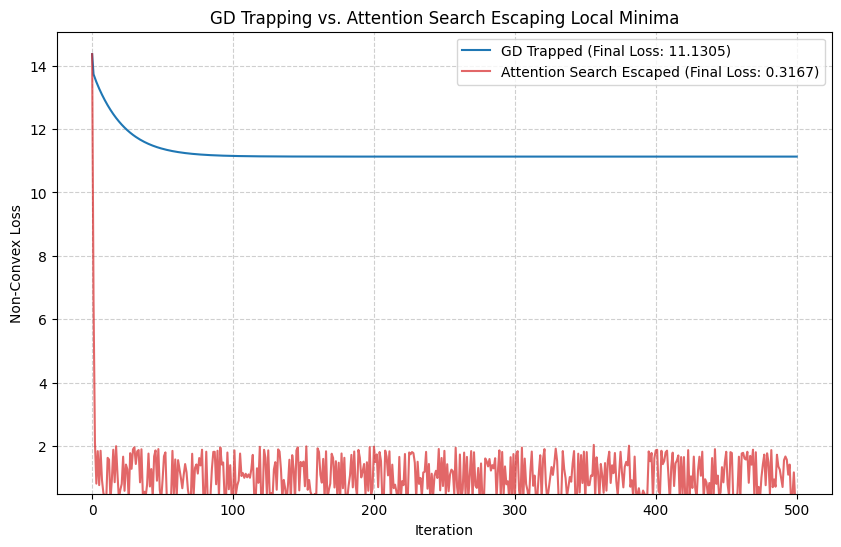

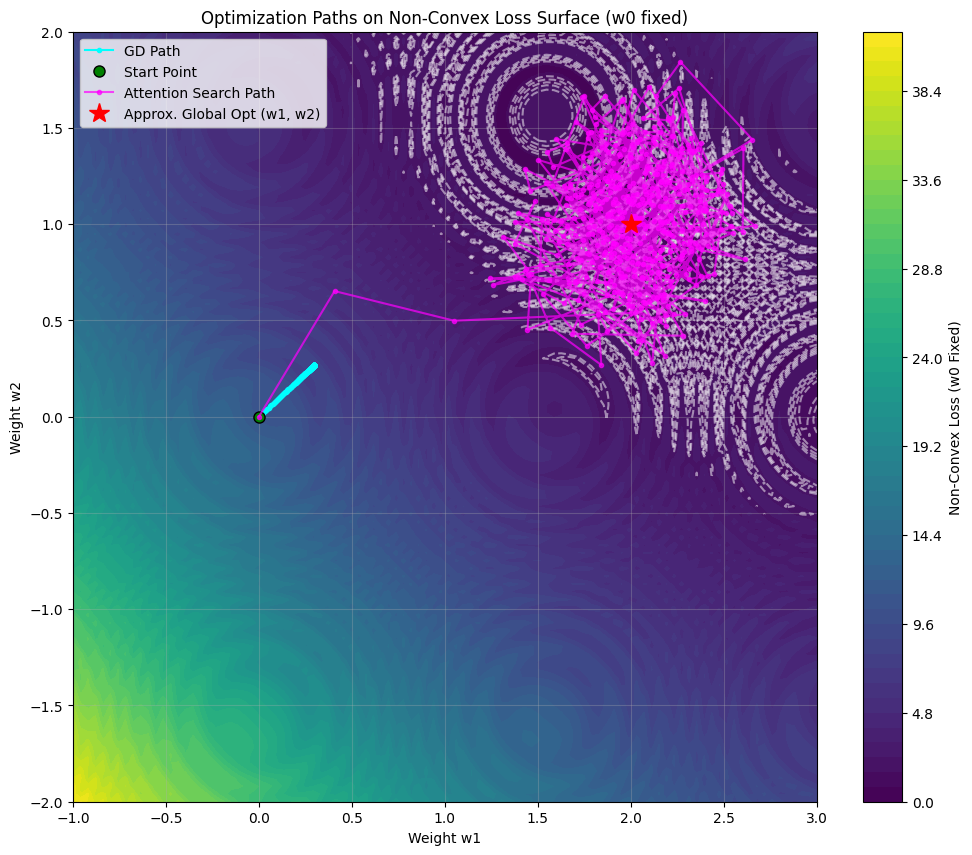

In [ ]:
# Non-Convex Loss Function with sharper traps
def loss_non_convex_trapped(w, X, y, lambda_osc=0.8, scale_osc=50):
    y_pred = X.dot(w)
    mse = np.mean((y_pred - y)**2)

    # Oscillation term based on the magnitude of weights
    w_magnitude_sq = np.sum(w**2) # w_magnitude_sq is w_0^2 + w_1^2 + w_2^2
    oscillation = lambda_osc * np.sin(scale_osc * w_magnitude_sq)

    # Add a fixed constant to ensure loss is positive
    return mse + oscillation + 1.0

def gradient_non_convex_trapped(w, X, y, lambda_osc=0.8, scale_osc=50):
    m = len(y)
    errors = X.dot(w) - y
    grad_mse = (2/m) * X.T.dot(errors)
    w_magnitude_sq = np.sum(w**2)
    grad_osc = lambda_osc * np.cos(scale_osc * w_magnitude_sq) * (2 * scale_osc * w)
    return grad_mse + grad_osc

# Data Generation for 3-Parameter Problem (w0, w1, w2)
np.random.seed(42)
N_SAMPLES = 100
X = 2 * np.random.rand(N_SAMPLES, 2)
X_b = np.c_[np.ones((N_SAMPLES, 1)), X]
true_w = np.array([[1.0], [2.0], [1.0]])
y = X_b.dot(true_w) + np.random.randn(N_SAMPLES, 1) * 0.1

#These functions track the step
def tracking_gradient_descent_trapped(start_w, X_b, y, learning_rate=0.001, n_iterations=1000, initial_w=None):
    w = start_w.copy()
    loss_history = []
    path_history = []

    # Record initial state BEFORE first step
    loss_history.append(loss_non_convex_trapped(w, X_b, y))
    path_history.append(w.flatten())

    for _ in range(n_iterations):
        grad = gradient_non_convex_trapped(w, X_b, y)
        w = w - learning_rate * grad
        loss_history.append(loss_non_convex_trapped(w, X_b, y))
        path_history.append(w.flatten())

    return w, loss_history[-1], loss_history, np.array(path_history)

def tracking_attention_search_escape(start_w, X, y, n_iterations=1000, n_samples=30, sigma=0.5):
    w = start_w.copy()
    loss_history = []
    path_history = []

    # Record initial state BEFORE first step
    loss_history.append(loss_non_convex_trapped(w, X, y))
    path_history.append(w.flatten())

    for _ in range(n_iterations):
        noise = np.random.randn(n_samples, w.shape[0]) * sigma
        trial_ws = w.T + noise

        # Scoring and Attention
        losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -10 * losses
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))

        # Context Vector Update
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new
        loss_history.append(loss_non_convex_trapped(w, X, y))
        path_history.append(w.flatten()) # Store the full w vector

    return w, loss_history[-1], loss_history, np.array(path_history)

N_ITERS = 500
start_w = np.array([[0.5], [0.0], [0.0]])

w_gd, loss_gd, hist_gd, path_gd = tracking_gradient_descent_trapped(start_w, X_b, y, n_iterations=N_ITERS, initial_w=start_w)
w_attn, loss_attn, hist_attn, path_attn = tracking_attention_search_escape(start_w, X_b, y, n_iterations=N_ITERS)


print("\nNon-Convex Trapping Scenario")
print(f"GD Learning Rate: 0.001 | GD Final Loss (Trapped): {loss_gd:.4f}")
print(f"Attn Search Sigma: 0.5 | Attn Final Loss (Escaped): {loss_attn:.4f}")

# Plotting Loss History
plt.figure(figsize=(10, 6))
plt.plot(hist_gd, label=f'GD Trapped (Final Loss: {loss_gd:.4f})', color='tab:blue')
plt.plot(hist_attn, label=f'Attention Search Escaped (Final Loss: {loss_attn:.4f})', color='tab:red', alpha=0.7)

plt.title('GD Trapping vs. Attention Search Escaping Local Minima')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.5)
plt.show()

# --- Heatmap Visualization ---
plt.figure(figsize=(12, 10))

W1_range = np.linspace(-1, 3, 100)
W2_range = np.linspace(-2, 2, 100)
W1_grid, W2_grid = np.meshgrid(W1_range, W2_range)
Z_loss_surface = np.zeros(W1_grid.shape)

fixed_w0 = true_w[0, 0]

for i in range(W1_grid.shape[0]):
    for j in range(W1_grid.shape[1]):
        w_temp = np.array([[fixed_w0], [W1_grid[i, j]], [W2_grid[i, j]]])
        Z_loss_surface[i, j] = loss_non_convex_trapped(w_temp, X_b, y)

# Create the heatmap
CS = plt.contourf(W1_grid, W2_grid, Z_loss_surface, levels=50, cmap='viridis')
plt.colorbar(CS, label='Non-Convex Loss (w0 Fixed)')
plt.contour(W1_grid, W2_grid, Z_loss_surface, levels=[1.0, 1.2, 1.4, 1.6, 1.8], colors='white', alpha=0.5, linestyles='--')

# Plot GD Path
plt.plot(path_gd[:, 1], path_gd[:, 2], 'o-', color='cyan', label='GD Path', markersize=3, linewidth=1.5)
plt.plot(path_gd[0, 1], path_gd[0, 2], 'go', markersize=8, label='Start Point', markeredgecolor='black') # Start

# Plot Attention Search Path
plt.plot(path_attn[:, 1], path_attn[:, 2], 'o-', color='magenta', label='Attention Search Path', markersize=3, linewidth=1.5, alpha=0.7)

# Mark True MSE Optimum (if the oscillation didn't shift it too much)
# The true_w for MSE part is [1.0, 2.0, 1.0]. We plot (w1=2.0, w2=1.0)
plt.plot(true_w[1], true_w[2], 'r*', markersize=15, label='Approx. Global Opt (w1, w2)')


plt.title('Optimization Paths on Non-Convex Loss Surface (w0 fixed)')
plt.xlabel('Weight w1')
plt.ylabel('Weight w2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def generate_data(n_samples, n_features, model_type):
    # +1 for the bias term
    X = np.random.randn(n_samples, n_features)
    X_b = np.c_[np.ones((n_samples, 1)), X]

    # True weights (random for high dim)
    true_w = np.random.randn(n_features + 1, 1) * 0.5

    if model_type == 'linear':
        y = X_b.dot(true_w) + np.random.randn(n_samples, 1) * 0.1
        loss_func = lambda w, X, y: np.mean((X.dot(w) - y)**2) # MSE
    elif model_type == 'logistic':
        y_raw = X_b.dot(true_w)
        y = (1 / (1 + np.exp(-y_raw)) > 0.5).astype(int) # Sigmoid and threshold
        loss_func = lambda w, X, y: -np.mean(y * np.log(1 / (1 + np.exp(-X.dot(w))) + 1e-10) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-X.dot(w))) + 1e-10))
    else:
        raise ValueError("Invalid model type")

    return X_b, y, true_w, loss_func

Using our method for hyperparameter tuning

In [ ]:
# Simple Linear Regression
def train_gd_model(learning_rate, X_train, y_train, X_val, y_val, epochs=50):
    w = np.random.randn(X_train.shape[1], 1)
    m = len(y_train)

    for _ in range(epochs):
        errors = X_train.dot(w) - y_train
        gradient = (2/m) * X_train.T.dot(errors)
        w = w - learning_rate * gradient

    # Validation Loss (The score our search method minimizes)
    val_loss = np.mean((X_val.dot(w) - y_val)**2)
    return val_loss

# Data for Hyperparameter Test
np.random.seed(1)
X_hp, y_hp, _, _ = generate_data(500, 2, 'linear') # Re-using a simple linear data generator
X_train_hp, X_temp_hp, y_train_hp, y_temp_hp = train_test_split(X_hp, y_hp, test_size=0.4)
X_val_hp, _, y_val_hp, _ = train_test_split(X_temp_hp, y_temp_hp, test_size=0.5)

In [ ]:
def attention_search_hp(X_train, y_train, X_val, y_val, n_iters=10, n_samples=5, sigma=0.1):
    best_alpha = 0.05 # Initial guess for the best learning rate
    history = []

    start_time = time.perf_counter()

    for _ in range(n_iters):
        alpha_noise = np.random.randn(n_samples) * sigma
        trial_alphas = np.maximum(1e-5, best_alpha + alpha_noise)
        losses = np.array([
            train_gd_model(alpha, X_train, y_train, X_val, y_val)
            for alpha in trial_alphas
        ])

        # Attention weights
        scores = -10 * losses
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
        best_alpha = np.sum(trial_alphas * weights)
        history.append(best_alpha)

    total_time = time.perf_counter() - start_time
    best_loss = train_gd_model(best_alpha, X_train, y_train, X_val, y_val)

    return best_alpha, best_loss, total_time, history

def grid_search_hp(X_train, y_train, X_val, y_val, search_space):
    best_alpha = None
    min_loss = np.inf

    start_time = time.perf_counter()

    for alpha in search_space:
        loss = train_gd_model(alpha, X_train, y_train, X_val, y_val)
        if loss < min_loss:
            min_loss = loss
            best_alpha = alpha

    total_time = time.perf_counter() - start_time
    return best_alpha, min_loss, total_time

def random_search_hp(X_train, y_train, X_val, y_val, n_trials, alpha_min, alpha_max):
    best_alpha = None
    min_loss = np.inf

    start_time = time.perf_counter()

    for _ in range(n_trials):
        alpha = np.random.uniform(alpha_min, alpha_max)
        loss = train_gd_model(alpha, X_train, y_train, X_val, y_val)
        if loss < min_loss:
            min_loss = loss
            best_alpha = alpha

    total_time = time.perf_counter() - start_time
    return best_alpha, min_loss, total_time

In [ ]:
ALPHA_MIN, ALPHA_MAX = 0.005, 0.2
N_TRIALS = 50

grid_alphas = np.linspace(ALPHA_MIN, ALPHA_MAX, N_TRIALS)
alpha_grid, loss_grid, time_grid = grid_search_hp(X_train_hp, y_train_hp, X_val_hp, y_val_hp, grid_alphas)

alpha_rand, loss_rand, time_rand = random_search_hp(X_train_hp, y_train_hp, X_val_hp, y_val_hp, N_TRIALS, ALPHA_MIN, ALPHA_MAX)

N_ATTN_ITERS = 10
N_ATTN_SAMPLES = 5
alpha_attn, loss_attn, time_attn, hist_attn = attention_search_hp(X_train_hp, y_train_hp, X_val_hp, y_val_hp,
                                                                 n_iters=N_ATTN_ITERS, n_samples=N_ATTN_SAMPLES)


print("\nCode 2: Hyperparameter Search Comparison")
print(f"Total Model Evaluation Budget: {N_TRIALS} (Grid/Random) vs {N_ATTN_ITERS * N_ATTN_SAMPLES} (Attention)")

print("\n| Method | Best Alpha | Min Loss | Total Time (s) |")
print(f"| Grid Search | {alpha_grid:.4f} | {loss_grid:.4f} | {time_grid:.4f} |")
print(f"| Random Search | {alpha_rand:.4f} | {loss_rand:.4f} | {time_rand:.4f} |")
print(f"| Attention Search | {alpha_attn:.4f} | {loss_attn:.4f} | {time_attn:.4f} |")


Code 2: Hyperparameter Search Comparison
Total Model Evaluation Budget: 50 (Grid/Random) vs 50 (Attention)

| Method | Best Alpha | Min Loss | Total Time (s) |
| Grid Search | 0.0607 | 0.0114 | 0.0222 |
| Random Search | 0.0528 | 0.0113 | 0.0182 |
| Attention Search | 0.1169 | 0.0114 | 0.0191 |


## Hybrid 1: GD to explore, attention to escape
Implemented the hybrid_gd_to_attn_optimizer to allow for repeated switching between Gradient Descent and Attention Search.


Starting hybrid GD-to-Attn optimizer for 1000 iterations...
[265/1000] GD plateau/phase end detected. Switching to Attention Search.
[285/1000] Attention Search phase completed. Switching back to GD.
Hybrid GD-to-Attn optimizer finished. Final mode: GD
Hybrid 1 Optimizer Comparison
Start Point: [0.5 0.  0. ]

| Optimizer          | Final Loss | Total Iterations |
| Baseline GD        | 11.1305   | 1000            |
| Baseline Attn      | 0.2989   | 1000            |
| Hybrid 1 (GD->Attn)| 2.3064   | 1000            |


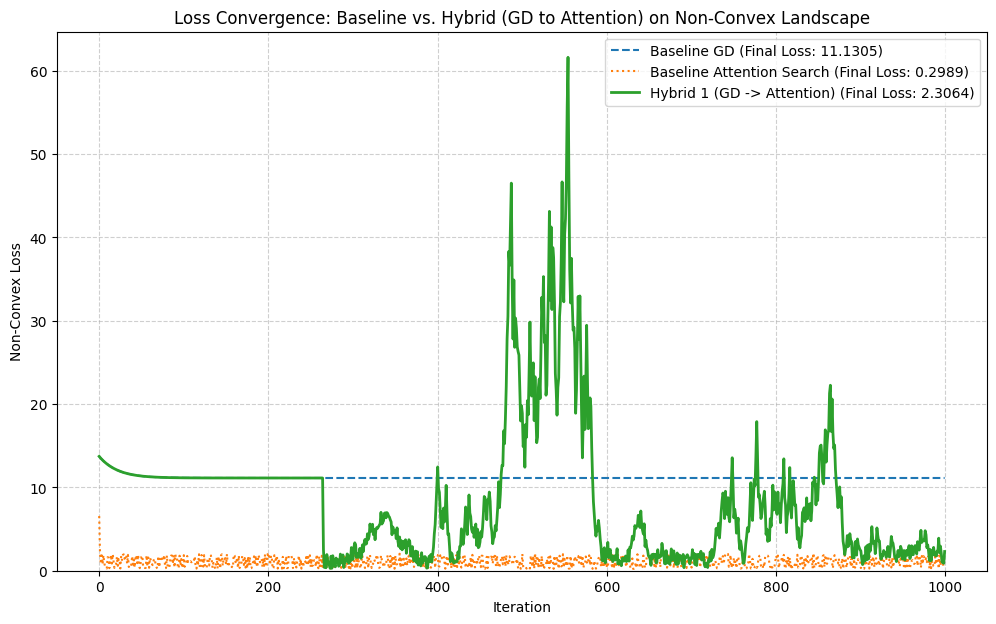

In [ ]:
def loss_non_convex_trapped(w, X, y, lambda_osc=0.8, scale_osc=50):
    y_pred = X.dot(w)
    mse = np.mean((y_pred - y)**2)
    w_magnitude_sq = np.sum(w**2)
    oscillation = lambda_osc * np.sin(scale_osc * w_magnitude_sq)
    return mse + oscillation + 1.0

def gradient_non_convex_trapped(w, X, y, lambda_osc=0.8, scale_osc=50):
    m = len(y)
    errors = X.dot(w) - y
    grad_mse = (2/m) * X.T.dot(errors)
    w_magnitude_sq = np.sum(w**2)
    grad_osc = lambda_osc * np.cos(scale_osc * w_magnitude_sq) * (2 * scale_osc * w)
    return grad_mse + grad_osc

np.random.seed(42)
N_SAMPLES = 100
X = 2 * np.random.rand(N_SAMPLES, 2)
X_b = np.c_[np.ones((N_SAMPLES, 1)), X]
true_w = np.array([[1.0], [2.0], [1.0]])
y = X_b.dot(true_w) + np.random.randn(N_SAMPLES, 1) * 0.1

def gradient_descent_optimizer_nc(X_b, y, learning_rate=0.001, n_iterations=1000, initial_w=None):
    w = initial_w.copy() if initial_w is not None else np.random.randn(X_b.shape[1], 1) * 0.5
    loss_history = []

    for _ in range(n_iterations):
        grad = gradient_non_convex_trapped(w, X_b, y)
        w = w - learning_rate * grad
        loss_history.append(loss_non_convex_trapped(w, X_b, y))

    return w, loss_history[-1], loss_history

def attention_search_optimizer_nc(initial_w, X, y, n_iterations=1000, n_samples=30, sigma=0.5):
    w = initial_w.copy()
    loss_history = []

    for _ in range(n_iterations):
        noise = np.random.randn(n_samples, w.shape[0]) * sigma
        trial_ws = w.T + noise
        losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -10 * losses # Beta fixed to be 10
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores))) # Stable softmax
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new
        loss_history.append(loss_non_convex_trapped(w, X, y))

    return w, loss_history[-1], loss_history

def hybrid_gd_to_attn_optimizer(X_b, y, initial_w, gd_learning_rate=0.001, gd_steps_per_phase=50, attn_n_samples=30, attn_sigma_explore=0.5, attn_beta=10, attn_steps_per_phase=20, patience=20, loss_tol=1e-5, max_total_iterations=1000):
    w = initial_w.copy()
    loss_history = []
    current_mode = "GD"
    steps_in_current_mode = 0
    plateau_count = 0
    prev_losses = []

    print(f"Starting hybrid GD-to-Attn optimizer for {max_total_iterations} iterations...")

    for i in range(max_total_iterations):
        if current_mode == "GD":
            grad = gradient_non_convex_trapped(w, X_b, y)
            w = w - gd_learning_rate * grad
            current_loss = loss_non_convex_trapped(w, X_b, y)
            loss_history.append(current_loss)

            prev_losses.append(current_loss)
            if len(prev_losses) > patience:
                prev_losses.pop(0)

            # Check for plateau if enough history is collected
            if len(prev_losses) == patience:
                if (np.max(prev_losses) - np.min(prev_losses)) < loss_tol:
                    plateau_count += 1
                else:
                    plateau_count = 0

            steps_in_current_mode += 1

            if plateau_count >= 2:
                current_mode = "Attention"
                steps_in_current_mode = 0
                plateau_count = 0
                prev_losses = []
                print(f"[{i+1}/{max_total_iterations}] GD plateau/phase end detected. Switching to Attention Search.")

        elif current_mode == "Attention":
            # Perform one step of Attention Search
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma_explore
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X_b, y) for tw in trial_ws])
            scores = -attn_beta * losses # Fixed beta
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            current_loss = loss_non_convex_trapped(w, X_b, y)
            loss_history.append(current_loss)

            steps_in_current_mode += 1

            if steps_in_current_mode >= attn_steps_per_phase:
                current_mode = "GD"
                steps_in_current_mode = 0
                plateau_count = 0
                prev_losses = []
                print(f"[{i+1}/{max_total_iterations}] Attention Search phase completed. Switching back to GD.")

    print(f"Hybrid GD-to-Attn optimizer finished. Final mode: {current_mode}")
    return w, loss_history[-1], loss_history

N_ITERS_TOTAL = 1000
START_W = np.array([[0.5], [0.0], [0.0]]) # Common initial weights for fair comparison
w_gd_base, loss_gd_base, hist_gd_base = gradient_descent_optimizer_nc(
    X_b, y, learning_rate=0.001, n_iterations=N_ITERS_TOTAL, initial_w=START_W
)
w_attn_base, loss_attn_base, hist_attn_base = attention_search_optimizer_nc(
    START_W, X_b, y, n_iterations=N_ITERS_TOTAL, n_samples=30, sigma=0.5
)
w_hybrid1, loss_hybrid1, hist_hybrid1 = hybrid_gd_to_attn_optimizer(
    X_b, y, START_W,
    gd_learning_rate=0.001,
    gd_steps_per_phase=50,             # GD runs for 50 steps before considering switch
    attn_n_samples=30,
    attn_sigma_explore=0.5,
    attn_beta=10,
    attn_steps_per_phase=20,            # Attention Search runs for 20 steps before switching back
    patience=20,                        # How many iterations without improvement to detect plateau
    loss_tol=1e-5,                      # Threshold for loss change to detect plateau
    max_total_iterations=N_ITERS_TOTAL
)

print("Hybrid 1 Optimizer Comparison")
print(f"Start Point: {START_W.flatten()}\n")

print("| Optimizer          | Final Loss | Total Iterations |")
print(f"| Baseline GD        | {loss_gd_base:.4f}   | {len(hist_gd_base)}            |")
print(f"| Baseline Attn      | {loss_attn_base:.4f}   | {len(hist_attn_base)}            |")
print(f"| Hybrid 1 (GD->Attn)| {loss_hybrid1:.4f}   | {len(hist_hybrid1)}            |")

plt.figure(figsize=(12, 7))
plt.plot(hist_gd_base, label=f'Baseline GD (Final Loss: {loss_gd_base:.4f})', color='tab:blue', linestyle='--')
plt.plot(hist_attn_base, label=f'Baseline Attention Search (Final Loss: {loss_attn_base:.4f})', color='tab:orange', linestyle=':')
plt.plot(hist_hybrid1, label=f'Hybrid 1 (GD -> Attention) (Final Loss: {loss_hybrid1:.4f})', color='tab:green', linewidth=2)

plt.title('Loss Convergence: Baseline vs. Hybrid (GD to Attention) on Non-Convex Landscape')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.0) # Ensure a reasonable y-axis start for non-convex loss
plt.show()

## Hybrid 2: Alternating Optimization
Implementing the hybrid_alternating_optimizer. Adjust gd_steps_per_cycle and attn_steps_per_cycle to optimize the balance between local exploitation by GD and global exploration by Attention Search within each alternating cycle for the non-convex landscape.


Starting alternating hybrid optimization for 50 cycles...
Alternating hybrid optimization finished. Total iterations: 1000
Hybrid 2 Optimizer Comparison
Start Point: [0.5 0.  0. ]

| Optimizer          | Final Loss | Total Iterations |
| Baseline GD        | 11.1305   | 1000            |
| Baseline Attn      | 1.0057   | 1000            |
| Hybrid 2 (Alternating)| 0.4736   | 1000            |


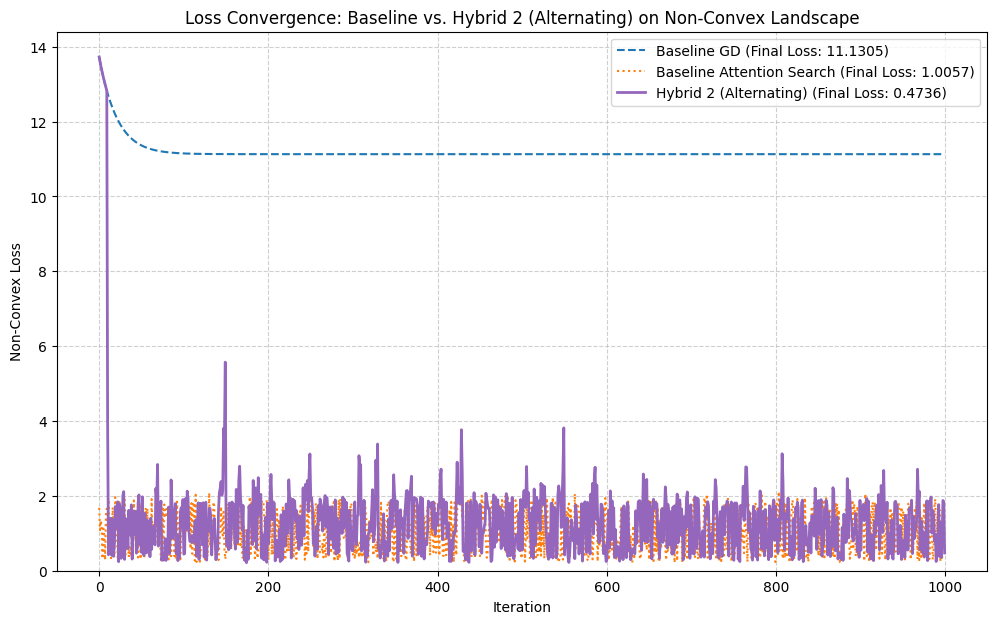

In [ ]:
def hybrid_alternating_optimizer(X_b, y, initial_w, gd_learning_rate=0.001, gd_steps_per_cycle=10, attn_n_samples=30, attn_sigma=0.5, attn_beta=10, attn_steps_per_cycle=10, total_cycles=50):
    w = initial_w.copy()
    loss_history = []

    print(f"Starting alternating hybrid optimization for {total_cycles} cycles...")

    for cycle in range(total_cycles):
        for _ in range(gd_steps_per_cycle):
            grad = gradient_non_convex_trapped(w, X_b, y)
            w = w - gd_learning_rate * grad
            loss_history.append(loss_non_convex_trapped(w, X_b, y))
        for _ in range(attn_steps_per_cycle):
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X_b, y) for tw in trial_ws])
            scores = -attn_beta * losses
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            loss_history.append(loss_non_convex_trapped(w, X_b, y))

    print(f"Alternating hybrid optimization finished. Total iterations: {len(loss_history)}")
    return w, loss_history[-1], loss_history

N_ITERS_TOTAL = 1000
START_W = np.array([[0.5], [0.0], [0.0]])

N_ITERS_GD_CYCLE = 10
N_ITERS_ATTN_CYCLE = 10
TOTAL_CYCLES = N_ITERS_TOTAL // (N_ITERS_GD_CYCLE + N_ITERS_ATTN_CYCLE)

w_gd_base, loss_gd_base, hist_gd_base = gradient_descent_optimizer_nc(
    X_b, y, learning_rate=0.001, n_iterations=N_ITERS_TOTAL, initial_w=START_W
)
w_attn_base, loss_attn_base, hist_attn_base = attention_search_optimizer_nc(
    START_W, X_b, y, n_iterations=N_ITERS_TOTAL, n_samples=30, sigma=0.5
)
w_hybrid2, loss_hybrid2, hist_hybrid2 = hybrid_alternating_optimizer(
    X_b, y, START_W, gd_learning_rate=0.001, gd_steps_per_cycle=N_ITERS_GD_CYCLE,
    attn_n_samples=30, attn_sigma=0.5, attn_beta=10, attn_steps_per_cycle=N_ITERS_ATTN_CYCLE,
    total_cycles=TOTAL_CYCLES
)
print("Hybrid 2 Optimizer Comparison")
print(f"Start Point: {START_W.flatten()}\n")

print("| Optimizer          | Final Loss | Total Iterations |")
print(f"| Baseline GD        | {loss_gd_base:.4f}   | {len(hist_gd_base)}            |")
print(f"| Baseline Attn      | {loss_attn_base:.4f}   | {len(hist_attn_base)}            |")
print(f"| Hybrid 2 (Alternating)| {loss_hybrid2:.4f}   | {len(hist_hybrid2)}            |")

plt.figure(figsize=(12, 7))
plt.plot(hist_gd_base, label=f'Baseline GD (Final Loss: {loss_gd_base:.4f})', color='tab:blue', linestyle='--')
plt.plot(hist_attn_base, label=f'Baseline Attention Search (Final Loss: {loss_attn_base:.4f})', color='tab:orange', linestyle=':')
plt.plot(hist_hybrid2, label=f'Hybrid 2 (Alternating) (Final Loss: {loss_hybrid2:.4f})', color='tab:purple', linewidth=2)

plt.title('Loss Convergence: Baseline vs. Hybrid 2 (Alternating) on Non-Convex Landscape')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.0)
plt.show()

## Hybrid 3: Attention-initialized/Restarted GD
Implementing a hybrid optimizer where Attention Search is periodically used to find a new, potentially better, starting point for Gradient Descent. GD runs for a set number of iterations, then Attention Search explores and provides a new 'initial' weight vector for GD to restart from.

  Cycle 1/20: Running GD for 40 steps.
  Cycle 1/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 2/20: Running GD for 40 steps.
  Cycle 2/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 3/20: Running GD for 40 steps.
  Cycle 3/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 4/20: Running GD for 40 steps.
  Cycle 4/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 5/20: Running GD for 40 steps.
  Cycle 5/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 6/20: Running GD for 40 steps.
  Cycle 6/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 7/20: Running GD for 40 steps.
  Cycle 7/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 8/20: Running GD for 40 steps.
  Cycle 8/20: Running Attention Search for 10 steps to re-initialize GD.
  Cycle 9/20: Running GD for 40 steps.
  Cycle 9/20: Running Attention Search for 10 steps to re-initial

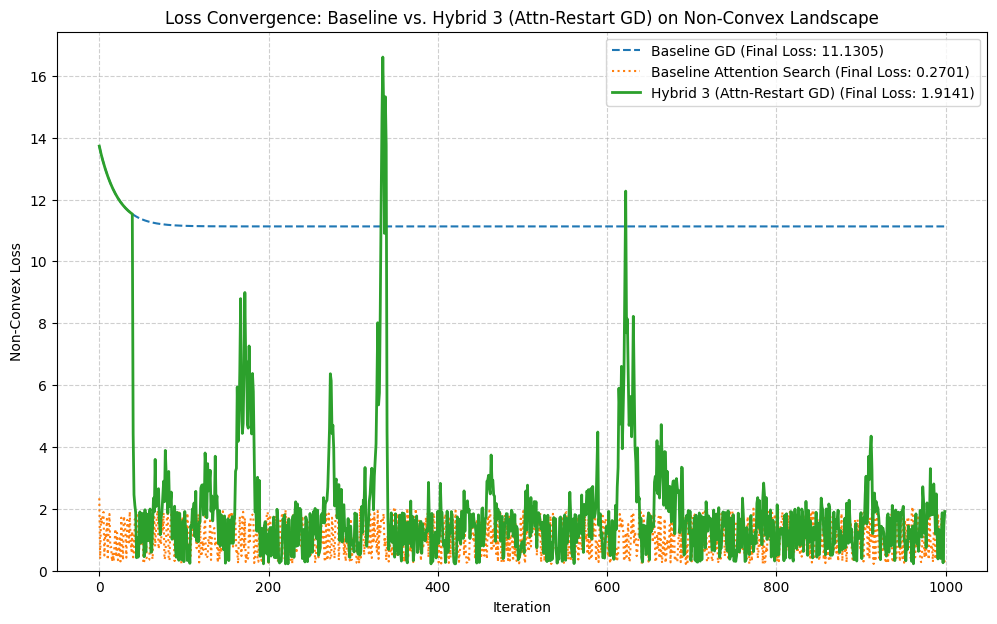

In [ ]:
def hybrid_attn_restart_gd_optimizer(X_b, y, initial_w, gd_learning_rate=0.001, gd_steps_per_restart=50, attn_n_samples=30, attn_sigma=0.5, attn_beta=10, attn_steps_per_restart=10, num_restarts=5):
    w = initial_w.copy()
    loss_history = []

    for cycle in range(num_restarts):
        print(f"  Cycle {cycle + 1}/{num_restarts}: Running GD for {gd_steps_per_restart} steps.")
        for _ in range(gd_steps_per_restart):
            grad = gradient_non_convex_trapped(w, X_b, y)
            w = w - gd_learning_rate * grad
            loss_history.append(loss_non_convex_trapped(w, X_b, y))

        print(f"  Cycle {cycle + 1}/{num_restarts}: Running Attention Search for {attn_steps_per_restart} steps to re-initialize GD.")
        for _ in range(attn_steps_per_restart):
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X_b, y) for tw in trial_ws])
            scores = -attn_beta * losses
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores))) # Stable softmax
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            loss_history.append(loss_non_convex_trapped(w, X_b, y))

    print(f"Hybrid 3 (Attn-restart GD) finished. Total iterations: {len(loss_history)}")
    return w, loss_history[-1], loss_history

N_ITERS_TOTAL = 1000
START_W = np.array([[0.5], [0.0], [0.0]])

w_gd_base, loss_gd_base, hist_gd_base = gradient_descent_optimizer_nc(
    X_b, y, learning_rate=0.001, n_iterations=N_ITERS_TOTAL, initial_w=START_W
)
w_attn_base, loss_attn_base, hist_attn_base = attention_search_optimizer_nc(
    START_W, X_b, y, n_iterations=N_ITERS_TOTAL, n_samples=30, sigma=0.5
)
GD_STEPS_PER_RESTART = 40
ATTN_STEPS_PER_RESTART = 10
NUM_RESTARTS = N_ITERS_TOTAL // (GD_STEPS_PER_RESTART + ATTN_STEPS_PER_RESTART)
w_hybrid3, loss_hybrid3, hist_hybrid3 = hybrid_attn_restart_gd_optimizer(
    X_b, y, START_W,
    gd_learning_rate=0.001,
    gd_steps_per_restart=GD_STEPS_PER_RESTART,
    attn_n_samples=30,
    attn_sigma=0.5,
    attn_beta=10,
    attn_steps_per_restart=ATTN_STEPS_PER_RESTART,
    num_restarts=NUM_RESTARTS
)

print("Hybrid 3 Optimizer Comparison")
print(f"Start Point: {START_W.flatten()}\n")

print("| Optimizer                             | Final Loss | Total Iterations |")
print(f"| Baseline GD                           | {loss_gd_base:.4f}   | {len(hist_gd_base)}            |")
print(f"| Baseline Attn                         | {loss_attn_base:.4f}   | {len(hist_attn_base)}            |")
print(f"| Hybrid 3 (Attn-Restart GD)      | {loss_hybrid3:.4f}   | {len(hist_hybrid3)}            |")

plt.figure(figsize=(12, 7))
plt.plot(hist_gd_base, label=f'Baseline GD (Final Loss: {loss_gd_base:.4f})', color='tab:blue', linestyle='--')
plt.plot(hist_attn_base, label=f'Baseline Attention Search (Final Loss: {loss_attn_base:.4f})', color='tab:orange', linestyle=':')
plt.plot(hist_hybrid3, label=f'Hybrid 3 (Attn-Restart GD) (Final Loss: {loss_hybrid3:.4f})', color='tab:green', linewidth=2)

plt.title('Loss Convergence: Baseline vs. Hybrid 3 (Attn-Restart GD) on Non-Convex Landscape')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0.0)
plt.show()


## High-Dimensional Optimization Comparison (100D, with Stats)



All Hybrid Optimizers Comparison (High-Dimensional)



,Optimizer,Final Loss,Total Iterations,Total Time (s),Avg Time/Iter (ms)
0,Baseline GD,6.256333,1000,0.181766,0.181766
1,Baseline Attn,2.081980,1000,3.565258,3.565258
2,Hybrid 1 (GD->Attn),6.256333,1000,0.142242,0.142242
3,Hybrid 2 (Alternating),4.134642,1000,1.421845,1.421845
4,Hybrid 3 (Attn-Restart GD),3.386147,1000,0.651816,0.651816
5,Hybrid 4 (Attn Meta-Optimizer GD),3.308862,1000,0.756758,0.756758


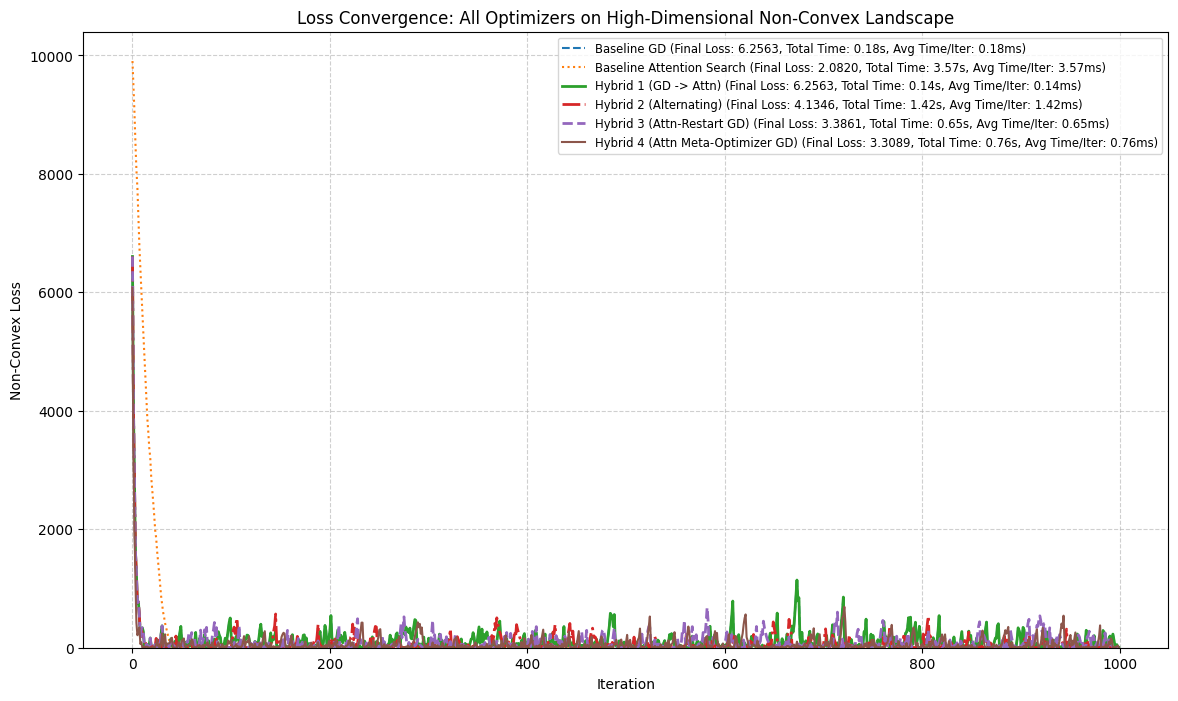

In [ ]:
np.random.seed(42)
N_SAMPLES = 100
N_FEATURES = 100
X_raw = 2 * np.random.rand(N_SAMPLES, N_FEATURES)
X_b = np.c_[np.ones((N_SAMPLES, 1)), X_raw]

true_w_list = [1.0] + [2.0] + [1.0] * (N_FEATURES - 1)
true_w = np.array(true_w_list).reshape(-1, 1)

y = X_b.dot(true_w) + np.random.randn(N_SAMPLES, 1) * 0.1

# Redefining the base optimizers to include time stats
def gradient_descent_optimizer_nc(initial_w, X_b, y, learning_rate=0.01, n_iterations=2000):
    start_time = time.perf_counter()
    w = initial_w
    loss_history = []

    for _ in range(n_iterations):
        grad = gradient_non_convex_trapped(w, X_b, y)
        w = w - learning_rate * grad
        loss_history.append(loss_non_convex_trapped(w, X_b, y))

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)
    return w, loss_history[-1], loss_history, total_time, time_per_iteration

def attention_search_optimizer_nc(initial_w, X, y, n_iterations=2000, n_samples=30, sigma=0.1):
    start_time = time.perf_counter()
    w = initial_w.copy()
    loss_history = []

    for _ in range(n_iterations):
        noise = np.random.randn(n_samples, w.shape[0]) * sigma
        trial_ws = w.T + noise
        losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), X, y) for tw in trial_ws])
        scores = -10 * losses # Fixed beta as 10
        weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
        w_new = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
        w = w_new
        loss_history.append(loss_non_convex_trapped(w, X, y))

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)
    return w, loss_history[-1], loss_history, total_time, time_per_iteration

# Hybrid 1: GD to Explore, Attention to Escape
def hybrid_gd_to_attn_optimizer(features_matrix, y, initial_w, gd_learning_rate=0.001, gd_steps_per_phase=50, attn_n_samples=30, attn_sigma_explore=0.5, attn_beta=10, attn_steps_per_phase=20, patience=20, loss_tol=1e-5, max_total_iterations=1000):
    start_time = time.perf_counter()
    w = initial_w.copy()
    loss_history = []
    current_mode = "GD"
    steps_in_current_mode = 0
    plateau_count = 0
    prev_losses = []

    for i in range(max_total_iterations):
        if current_mode == "GD":
            grad = gradient_non_convex_trapped(w, features_matrix, y)
            w = w - gd_learning_rate * grad
            current_loss = loss_non_convex_trapped(w, features_matrix, y)
            loss_history.append(current_loss)

            prev_losses.append(current_loss)
            if len(prev_losses) > patience:
                prev_losses.pop(0)

            if len(prev_losses) == patience:
                if (np.max(prev_losses) - np.min(prev_losses)) < loss_tol:
                    plateau_count += 1
                else:
                    plateau_count = 0

            steps_in_current_mode += 1

            if plateau_count >= 2:
                current_mode = "Attention"
                steps_in_current_mode = 0
                plateau_count = 0
                prev_losses = []

        elif current_mode == "Attention":
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma_explore
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), features_matrix, y) for tw in trial_ws])
            scores = -attn_beta * losses
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            current_loss = loss_non_convex_trapped(w, features_matrix, y)
            loss_history.append(current_loss)

            steps_in_current_mode += 1

            if steps_in_current_mode >= attn_steps_per_phase:
                current_mode = "GD"
                steps_in_current_mode = 0
                plateau_count = 0
                prev_losses = []

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)

    return w, loss_history[-1], loss_history, total_time, time_per_iteration

# Hybrid 2: Alternating GD and Attention Search
def hybrid_alternating_optimizer(features_matrix, y, initial_w, gd_learning_rate=0.001, gd_steps_per_cycle=10, attn_n_samples=30, attn_sigma=0.5, attn_beta=10, attn_steps_per_cycle=10, total_cycles=50):
    start_time = time.perf_counter()
    w = initial_w.copy()
    loss_history = []

    for cycle in range(total_cycles):
        for _ in range(gd_steps_per_cycle):
            grad = gradient_non_convex_trapped(w, features_matrix, y)
            w = w - gd_learning_rate * grad
            loss_history.append(loss_non_convex_trapped(w, features_matrix, y))

        for _ in range(attn_steps_per_cycle):
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), features_matrix, y) for tw in trial_ws])
            scores = -attn_beta * losses
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            loss_history.append(loss_non_convex_trapped(w, features_matrix, y))

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)

    return w, loss_history[-1], loss_history, total_time, time_per_iteration

# Hybrid 3: Attention-initialized/Restarted GD
def hybrid_attn_restart_gd_optimizer(features_matrix, y, initial_w, gd_learning_rate=0.001, gd_steps_per_restart=50, attn_n_samples=30, attn_sigma=0.5, attn_beta=10, attn_steps_per_restart=10, num_restarts=5):
    start_time = time.perf_counter()
    w = initial_w.copy()
    loss_history = []

    for cycle in range(num_restarts):
        for _ in range(gd_steps_per_restart):
            grad = gradient_non_convex_trapped(w, features_matrix, y)
            w = w - gd_learning_rate * grad
            loss_history.append(loss_non_convex_trapped(w, features_matrix, y))

        for _ in range(attn_steps_per_restart):
            noise = np.random.randn(attn_n_samples, w.shape[0]) * attn_sigma
            trial_ws = w.T + noise
            losses = np.array([loss_non_convex_trapped(tw.reshape(-1, 1), features_matrix, y) for tw in trial_ws])
            scores = -attn_beta * losses
            weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
            w = np.sum(trial_ws * weights[:, np.newaxis], axis=0).reshape(-1, 1)
            loss_history.append(loss_non_convex_trapped(w, features_matrix, y))

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)

    return w, loss_history[-1], loss_history, total_time, time_per_iteration

# Hybrid 4: Attention as a Meta-Optimizer for Learning Rate
def attention_meta_optimizer_gd(features_matrix, y, initial_w, n_iterations, initial_lr=0.001, lr_candidates_sigma=0.001, lr_attn_samples=10, lr_attn_beta=10):
    start_time = time.perf_counter()
    w = initial_w.copy()
    loss_history = []
    current_lr = initial_lr

    for i in range(n_iterations):
        grad = gradient_non_convex_trapped(w, features_matrix, y)

        lr_noise = np.random.randn(lr_attn_samples) * lr_candidates_sigma
        candidate_lrs = np.maximum(1e-6, current_lr + lr_noise)

        hypothetical_losses = []
        for lr_candidate in candidate_lrs:
            w_next_candidate = w - lr_candidate * grad
            hypothetical_losses.append(loss_non_convex_trapped(w_next_candidate, features_matrix, y))
        hypothetical_losses = np.array(hypothetical_losses)

        scores = -lr_attn_beta * hypothetical_losses
        lr_weights = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))

        chosen_lr = np.sum(candidate_lrs * lr_weights)

        w = w - chosen_lr * grad
        current_loss = loss_non_convex_trapped(w, features_matrix, y)
        loss_history.append(current_loss)

    end_time = time.perf_counter()
    total_time = end_time - start_time
    time_per_iteration = total_time / len(loss_history)

    return w, loss_history[-1], loss_history, total_time, time_per_iteration

START_W = np.random.randn(X_b.shape[1], 1) * 0.1
TOTAL_ITERS = 1000

w_gd_base, loss_gd_base, hist_gd_base, time_gd_base, iter_time_gd_base = gradient_descent_optimizer_nc(
    START_W, X_b, y, learning_rate=0.001, n_iterations=TOTAL_ITERS
)
w_attn_base, loss_attn_base, hist_attn_base, time_attn_base, iter_time_attn_base = attention_search_optimizer_nc(
    START_W, X_b, y, n_iterations=TOTAL_ITERS, n_samples=50, sigma=0.1
)

# Hybrid 1 Parameters
GD_STEPS_PER_PHASE_H1 = 50
ATTN_STEPS_PER_PHASE_H1 = 20
w_hybrid1, loss_hybrid1, hist_hybrid1, time_hybrid1, iter_time_hybrid1 = hybrid_gd_to_attn_optimizer(
    X_b, y, START_W,
    gd_learning_rate=0.001,
    gd_steps_per_phase=GD_STEPS_PER_PHASE_H1,
    attn_n_samples=50,
    attn_sigma_explore=0.1,
    attn_beta=10,
    attn_steps_per_phase=ATTN_STEPS_PER_PHASE_H1,
    patience=20,
    loss_tol=1e-5,
    max_total_iterations=TOTAL_ITERS
)

# Hybrid 2 Parameters
GD_STEPS_PER_CYCLE_H2 = 10
ATTN_STEPS_PER_CYCLE_H2 = 10
TOTAL_CYCLES_H2 = TOTAL_ITERS // (GD_STEPS_PER_CYCLE_H2 + ATTN_STEPS_PER_CYCLE_H2)
w_hybrid2, loss_hybrid2, hist_hybrid2, time_hybrid2, iter_time_hybrid2 = hybrid_alternating_optimizer(
    X_b, y, START_W,
    gd_learning_rate=0.001,
    gd_steps_per_cycle=GD_STEPS_PER_CYCLE_H2,
    attn_n_samples=50,
    attn_sigma=0.1,
    attn_beta=10,
    attn_steps_per_cycle=ATTN_STEPS_PER_CYCLE_H2,
    total_cycles=TOTAL_CYCLES_H2
)

# Hybrid 3 Parameters
GD_STEPS_PER_RESTART_H3 = 40
ATTN_STEPS_PER_RESTART_H3 = 10
NUM_RESTARTS_H3 = TOTAL_ITERS // (GD_STEPS_PER_RESTART_H3 + ATTN_STEPS_PER_RESTART_H3)
w_hybrid3, loss_hybrid3, hist_hybrid3, time_hybrid3, iter_time_hybrid3 = hybrid_attn_restart_gd_optimizer(
    X_b, y, START_W,
    gd_learning_rate=0.001,
    gd_steps_per_restart=GD_STEPS_PER_RESTART_H3,
    attn_n_samples=50,
    attn_sigma=0.1,
    attn_beta=10,
    attn_steps_per_restart=ATTN_STEPS_PER_RESTART_H3,
    num_restarts=NUM_RESTARTS_H3
)

# Hybrid 4 Parameters
w_hybrid4, loss_hybrid4, hist_hybrid4, time_hybrid4, iter_time_hybrid4 = attention_meta_optimizer_gd(
    X_b, y, START_W, n_iterations=TOTAL_ITERS,
    initial_lr=0.001, lr_candidates_sigma=0.0001,
    lr_attn_samples=20, lr_attn_beta=10
)

print("All Hybrid Optimizers Comparison (High-Dimensional)\n")
#print(f"Start Point (Total {len(START_W)} weights):\n")
#display(START_W)

data = {
    'Optimizer': [
        'Baseline GD',
        'Baseline Attn',
        'Hybrid 1 (GD->Attn)',
        'Hybrid 2 (Alternating)',
        'Hybrid 3 (Attn-Restart GD)',
        'Hybrid 4 (Attn Meta-Optimizer GD)'
    ],
    'Final Loss': [
        loss_gd_base,
        loss_attn_base,
        loss_hybrid1,
        loss_hybrid2,
        loss_hybrid3,
        loss_hybrid4
    ],
    'Total Iterations': [
        len(hist_gd_base),
        len(hist_attn_base),
        len(hist_hybrid1),
        len(hist_hybrid2),
        len(hist_hybrid3),
        len(hist_hybrid4)
    ],
    'Total Time (s)': [
        time_gd_base,
        time_attn_base,
        time_hybrid1,
        time_hybrid2,
        time_hybrid3,
        time_hybrid4
    ],
    'Avg Time/Iter (ms)': [
        iter_time_gd_base * 1000,
        iter_time_attn_base * 1000,
        iter_time_hybrid1 * 1000,
        iter_time_hybrid2 * 1000,
        iter_time_hybrid3 * 1000,
        iter_time_hybrid4 * 1000
    ]
}

df_results = pd.DataFrame(data)
display(df_results)

plt.figure(figsize=(14, 8))
plt.plot(hist_gd_base, label=f'Baseline GD (Final Loss: {loss_gd_base:.4f}, Total Time: {time_gd_base:.2f}s, Avg Time/Iter: {iter_time_gd_base*1000:.2f}ms)', color='tab:blue', linestyle='--')
plt.plot(hist_attn_base, label=f'Baseline Attention Search (Final Loss: {loss_attn_base:.4f}, Total Time: {time_attn_base:.2f}s, Avg Time/Iter: {iter_time_attn_base*1000:.2f}ms)', color='tab:orange', linestyle=':')
plt.plot(hist_hybrid1, label=f'Hybrid 1 (GD -> Attn) (Final Loss: {loss_hybrid1:.4f}, Total Time: {time_hybrid1:.2f}s, Avg Time/Iter: {iter_time_hybrid1*1000:.2f}ms)', color='tab:green', linewidth=2)
plt.plot(hist_hybrid2, label=f'Hybrid 2 (Alternating) (Final Loss: {loss_hybrid2:.4f}, Total Time: {time_hybrid2:.2f}s, Avg Time/Iter: {iter_time_hybrid2*1000:.2f}ms)', color='tab:red', linestyle='-.', linewidth=2)
plt.plot(hist_hybrid3, label=f'Hybrid 3 (Attn-Restart GD) (Final Loss: {loss_hybrid3:.4f}, Total Time: {time_hybrid3:.2f}s, Avg Time/Iter: {iter_time_hybrid3*1000:.2f}ms)', color='tab:purple', linestyle='--', linewidth=2)
plt.plot(hist_hybrid4, label=f'Hybrid 4 (Attn Meta-Optimizer GD) (Final Loss: {loss_hybrid4:.4f}, Total Time: {time_hybrid4:.2f}s, Avg Time/Iter: {iter_time_hybrid4*1000:.2f}ms)', color='tab:brown', linestyle='-', linewidth=1.5)

plt.title('Loss Convergence: All Optimizers on High-Dimensional Non-Convex Landscape')
plt.xlabel('Iteration')
plt.ylabel('Non-Convex Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize='small', loc='upper right')
plt.ylim(bottom=0.0)
plt.show()